In [1]:
import os
import pickle
import itertools
import numpy as np
from numpy import float, int
import pandas as pd
from matplotlib import pyplot
from IPython.display import HTML, display

from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [2]:
# Display
%matplotlib
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

plt.style.use('seaborn-dark')

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


## Helpers

### IPython

In [3]:
def display_pb(iterable, index=False):
  length = len(iterable)
  def progress_bar(value=0, length=length):
      return HTML("""
          <progress
              value='{value}'
              max='{max}',
              style='width: 100%'
          >
              {value}
          </progress>
      """.format(value=value, max=length))
  
  out = display(progress_bar(), display_id=True)
  for i, j in enumerate(iterable):
    yield (i, j) if index else j
    progress = i + 1
    out.update(progress_bar(progress))


### EVALUATION METRICS

In [4]:
def mse(y_hat, y):
    return ((y_hat - y) ** 2).mean()


def rmse(y_hat, y):
    return np.sqrt(mse(y_hat, y))


def bin_class_dev(p_hat, y, pos_cat=None, tiny=1e-32):
    if hasattr(y, 'cat'):
        y_bool = y == pos_cat
    else:
        y_bool = y.astype(bool)
    return - 2 * (y_bool * np.log(p_hat + tiny) + (1 - y_bool) * np.log(1 - p_hat + tiny)).mean()


def bin_classif_eval_hard_pred(hard_predictions, actuals, pos_cat=None):
    if hasattr(hard_predictions, 'cat'):
        hard_predictions_bool = hard_predictions == pos_cat
    else:
        hard_predictions_bool = hard_predictions.astype(bool)

    if hasattr(actuals, 'cat'):
        actuals_bool = actuals == pos_cat
    else:
        actuals_bool = actuals.astype(bool)

    opposite_hard_predictions_bool = ~ hard_predictions_bool
    opposite_actuals_bool = ~ actuals_bool

    nb_samples = len(actuals)
    nb_pos = sum(actuals_bool)
    nb_neg = sum(opposite_actuals_bool)
    nb_pred_pos = sum(hard_predictions_bool)
    nb_pred_neg = sum(opposite_hard_predictions_bool)
    nb_true_pos = sum(hard_predictions_bool & actuals_bool)
    nb_true_neg = sum(opposite_hard_predictions_bool & opposite_actuals_bool)
    nb_false_pos = sum(hard_predictions_bool & opposite_actuals_bool)
    nb_false_neg = sum(opposite_hard_predictions_bool & actuals_bool)

    accuracy = (nb_true_pos + nb_true_neg) / nb_samples
    recall = nb_true_pos / nb_pos
    specificity = nb_true_neg / nb_neg
    precision = nb_true_pos / nb_pred_pos
    f1_score = (2 * precision * recall) / (precision + recall)

    return dict(
        accuracy=accuracy,
        recall=recall,
        specificity=specificity,
        precision=precision,
        f1_score=f1_score)


def bin_classif_eval(predictions, actuals, pos_cat=None, thresholds=.5):
    if hasattr(predictions, 'cat') or (predictions.dtype in ('bool', 'int')):
        return bin_classif_eval_hard_pred(predictions, actuals, pos_cat=pos_cat)

    if isinstance(thresholds, (float, int)):
        hard_predictions = predictions >= thresholds
        metrics = bin_classif_eval_hard_pred(hard_predictions, actuals, pos_cat=pos_cat)
        metrics['deviance'] = bin_class_dev(predictions, actuals, pos_cat=pos_cat)
    else:
        metrics = pd.DataFrame(columns=['threshold', 'accuracy', 'recall', 'specificity', 'precision', 'f1_score', 'deviance'])
        metrics.threshold = thresholds
        metrics.fillna(.0, inplace=True)

        for i, _ in enumerate(thresholds):
            m = bin_classif_eval(predictions, actuals, pos_cat=pos_cat, thresholds=thresholds[i])
            m['threshold'] = metrics.loc[i, 'threshold']
            metrics.loc[i] = m
    
    return metrics

## Load Data

In [5]:
target = 'churn' # churn appetency upselling

data_dir = './data/'
data_file = 'orange_small_train.data'
DATA_PATH = os.path.join(data_dir, data_file)

label_file = 'orange_small_train_{}.labels'.format(target)
LABEL_PATH = os.path.join(data_dir, label_file)

save_dir = './save/'
best_features_file = '{}_best_features.csv'.format(target)
BEST_FEATURES_PATH = os.path.join(save_dir, best_features_file)

model_file = '{}_model.pickle'.format(target)
MODEL_PATH = os.path.join(save_dir, model_file)

In [6]:
df = pd.read_csv(DATA_PATH, delimiter='\t')
df.head()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230
0,NaN,NaN,NaN,NaN,NaN,1526.0,7.0,NaN,NaN,NaN,...,oslk,fXVEsaq,jySVZNlOJy,NaN,NaN,xb3V,RAYp,F2FyR07IdsN7I,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,525.0,0.0,NaN,NaN,NaN,...,oslk,2Kb5FSF,LM8l689qOp,NaN,NaN,fKCe,RAYp,F2FyR07IdsN7I,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,5236.0,7.0,NaN,NaN,NaN,...,Al6ZaUT,NKv4yOc,jySVZNlOJy,NaN,kG3k,Qu4f,02N6s8f,ib5G6X1eUxUn6,am7c,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,oslk,CE7uk3u,LM8l689qOp,NaN,NaN,FSa2,RAYp,F2FyR07IdsN7I,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,1029.0,7.0,NaN,NaN,NaN,...,oslk,1J2cvxe,LM8l689qOp,NaN,kG3k,FSa2,RAYp,F2FyR07IdsN7I,mj86,NaN


In [7]:
df_label = pd.read_table(LABEL_PATH, header=None)
df_label[0] = df_label[0].astype('category').cat.rename_categories(['no', 'yes'])
df_label.head()

,0
0,no
1,yes
2,no
3,no
4,no


## Data Cleaning

In [8]:
df_columns = df.columns

for column in df_columns:
  series = df[column]
  tp = series.dtype
  if tp == int:
    df[column] = series.astype(float)
  elif tp != float:
    df[column] = series.astype('category')
    
columns_type = pd.Series([str(df[column].dtype) for column in df_columns]) 
columns_type.unique()

array(['float64', 'category'], dtype=object)

### Cleaning columns with high frequency of missing values

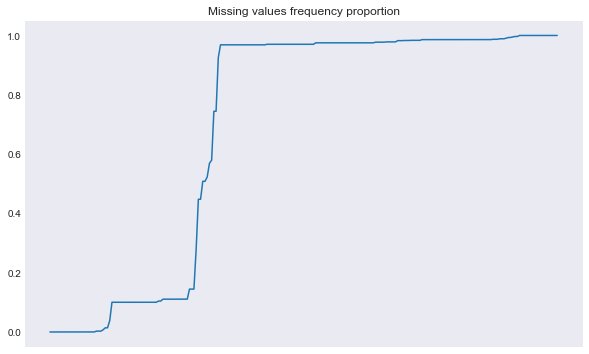

In [9]:
num_rows = len(df.index)
columns_null_freq = df.isnull().sum() / num_rows
columns_null_freq.sort_values().plot()
title('Missing values frequency proportion')
# savefig('./graphs/missing_values.png')

In [10]:
low_null_freq_columns = columns_null_freq[columns_null_freq < .2].index
df_c = df[low_null_freq_columns]
df_c_columns = df_c.columns
len(df_c_columns)

66

### Cleaning float columns

Looking for flot columns with no variation

In [11]:
float_columns = [column for column in df_c_columns if df_c[column].dtype == float]
df_float_columns = df_c[float_columns]

In [12]:
columns_deviation = df_float_columns.std()
len(columns_deviation[columns_deviation == 0])

0

Filling nan values with the column mean

In [13]:
df_float_columns.fillna(df_float_columns.mean(), inplace=True)
df_float_columns.isnull().sum().sum()

c:\users\yurih\appdata\local\programs\python\python36\lib\site-packages\pandas\core\generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


0

Assert that the columns mean don't change

In [14]:
np.allclose(df_c[float_columns].mean(), df_float_columns.mean())

True

### Cleaning categorical columns

In [15]:
category_columns = [column for column in df_c_columns if str(df_c[column].dtype) == 'category']
df_category_columns = df_c[category_columns]

Removing columns with the number of categories above 1000

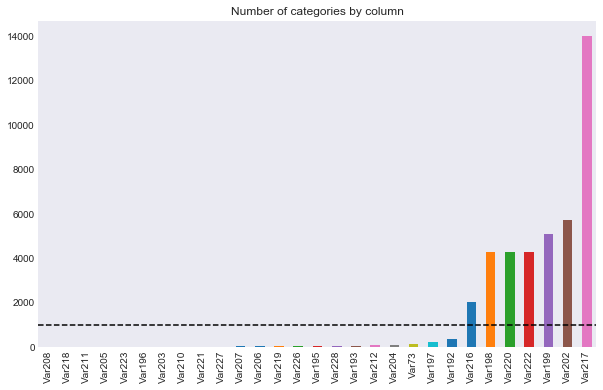

In [16]:
category_limit = 1000
num_categories_columns = df_category_columns.apply(lambda x: len(x.cat.categories))
ax = num_categories_columns.sort_values().plot.bar()
ax.axhline(category_limit, color='k', linestyle='dashed')

title('Number of categories by column')
# savefig('./graphs/num_categories_columns.png')

In [17]:
relevant_category_columns = num_categories_columns[num_categories_columns < category_limit].index
df_category_columns = df_category_columns[relevant_category_columns]
len(relevant_category_columns)

22

Setting 2 new categories for all columns:
- NULL: for blank data
- OTHER: to replace categories with less than 5% of representativity

After that, columns with less than two categories will be removed, the new categories don't count.

In [18]:
MIN_FREQ_RATE = .05
NULL_CATEGORY_LABEL = '__NULL__'
OTHER_CATEGORY_LABEL = '__OTHER__'

df_category_columns_refactored = df_category_columns.copy()
valid_category_columns = []

for column in relevant_category_columns:
  series = df_category_columns_refactored[column]
  series_null = series.isnull()
  if series_null.sum() > 0:
    series.cat.add_categories(NULL_CATEGORY_LABEL, inplace=True)
    series.fillna(NULL_CATEGORY_LABEL, inplace=True)
    
  categories_freq = series.groupby(series).count() / len(series)
  low_freq = categories_freq[categories_freq < MIN_FREQ_RATE].index
  if len(low_freq) > 0:
    series.cat.add_categories(OTHER_CATEGORY_LABEL, inplace=True)
    series.replace(low_freq, OTHER_CATEGORY_LABEL, inplace=True)
    series.cat.remove_categories(low_freq, inplace=True)
  
  df_category_columns_refactored[column] = series
  # Get columns that have at least 2 categories along
  # side the new ones (NULL, OTHER).
  categories = series.cat.categories
  old_categories = set(categories) - set([NULL_CATEGORY_LABEL, OTHER_CATEGORY_LABEL])
  if len(old_categories) > 1:
    valid_category_columns.append(column)
  
df_category_columns_refactored = df_category_columns_refactored[valid_category_columns]
print('Done!')

Done!


In [19]:
for column in df_category_columns_refactored.columns:
  s = df_category_columns_refactored[column]
  new_cf = s.groupby(s).count() / len(s)
  print(new_cf, '\n', '-'*50)

Var193
2Knk1KF      0.14542
RO12         0.71928
__OTHER__    0.13530
Name: Var193, dtype: float64 
 --------------------------------------------------
Var197
0Xwj         0.09258
487l         0.07154
JLbT         0.05956
TyGl         0.08370
__OTHER__    0.60322
lK27         0.08940
Name: Var197, dtype: float64 
 --------------------------------------------------
Var203
9_Y1         0.90466
HLqf         0.06336
__OTHER__    0.03198
Name: Var203, dtype: float64 
 --------------------------------------------------
Var205
09_Q         0.23148
VpdQ         0.63924
__OTHER__    0.03868
sJzTlal      0.09060
Name: Var205, dtype: float64 
 --------------------------------------------------
Var206
IYzP         0.34548
__NULL__     0.11058
__OTHER__    0.22090
hAFG         0.05626
haYg         0.05802
sYC_         0.08006
zm5i         0.12870
Name: Var206, dtype: float64 
 --------------------------------------------------
Var207
7M47J5GA0pTYIFxg5uy          0.13778
DHn_WUyBhW_whjA88g9bvA64_   

In [20]:
df_category_columns = df_category_columns_refactored
len(df_category_columns.columns)

15

### Join float and categorical columns

In [21]:
df_treated = pd.concat([df_float_columns, df_category_columns], axis=1)
len(df_treated.columns)

52

In [22]:
df_columns = df.columns
columns_type = pd.Series([str(df[column].dtype) for column in df_columns]) 
columns_type.unique()

array(['float64', 'category'], dtype=object)

## Spliting train and test data

In [23]:
TEST_DATA_SIZE = .6

sss = StratifiedShuffleSplit(n_splits=5, test_size=TEST_DATA_SIZE)
for train_index, test_index in sss.split(df_treated, df_label):
  X_train_valid, X_test = df_treated.iloc[train_index, :], df_treated.iloc[test_index, :]
  y_train_valid, y_test = df_label.iloc[train_index], df_label.loc[test_index]

VALID_DATA_SIZE = .25

sss = StratifiedShuffleSplit(n_splits=5, test_size=VALID_DATA_SIZE)
for train_index, valid_index in sss.split(X_train_valid, y_train_valid):
  X_train, X_valid = X_train_valid.iloc[train_index, :], X_train_valid.iloc[valid_index, :]
  y_train, y_valid = y_train_valid.iloc[train_index], y_train_valid.iloc[valid_index]

len(X_train)

15000

## Selecting the best combination of features

In [24]:
def get_RFC_model():
  B = 30
  return RandomForestClassifier(
    n_estimators=B,
    criterion='entropy',
    max_depth=None,   # expand until all leaves are pure or contain < MIN_SAMPLES_SPLIT samples
    min_samples_split=300,
    min_samples_leaf=150,
    min_weight_fraction_leaf=0.0,
    max_features=None,   # number of features to consider when looking for the best split; None: max_features=n_features
    max_leaf_nodes=None,   # None: unlimited number of leaf nodes
    bootstrap=True,
    oob_score=True,   # estimate Out-of-Bag Cross Entropy
#     n_jobs=cpu_count() - 2,   # paralellize over all CPU cores but 2
    class_weight=None,
#     random_state=RANDOM_SEED,
    verbose=0,
    warm_start=False
  )

Compute the performance for each pair of column in a Random Florest model. Using the train and validation data

In [25]:
column_pair_performance = pd.DataFrame(columns=['c1', 'c2', 'deviance'])
column_pairs = list(itertools.combinations(df_treated.columns, 2))

for i, pair in display_pb(column_pairs, index=True):
  c1, c2 = pair
  X_train_pair = pd.get_dummies(X_train[[c1, c2]])

  rf_model = get_RFC_model()
  rf_model.fit(X=X_train_pair, y=y_train.values.ravel())

  X_valid_dummies = pd.get_dummies(X_valid[[c1,c2]])
  predict_prob = rf_model.predict_proba(X=X_valid_dummies)[:, 1]
  deviance = bin_class_dev(p_hat=predict_prob, y=y_valid.values.ravel(), pos_cat='yes')
  column_pair_performance.loc[i] = c1, c2, deviance
  

c:\users\yurih\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\yurih\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\yurih\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\yurih\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\yurih\appdata\l

c:\users\yurih\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\yurih\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\yurih\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\yurih\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\yurih\appdata\l

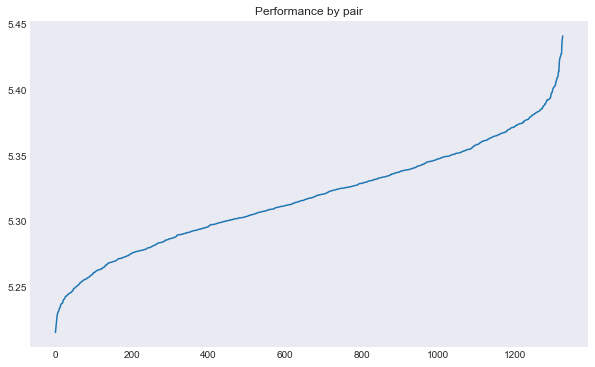

In [26]:
pd.Series(column_pair_performance.deviance.sort_values().values).plot()
title('Performance by pair')
# savefig('./graphs/performance_by_pair.png')

Sort and get the top half performances than break the pairs

In [27]:
half, _ = divmod(len(column_pair_performance), 2)
cpp_top_half = column_pair_performance.sort_values('deviance', ascending=False).head(half)
new_columns = ['column',]
a = cpp_top_half.c1
a.columns = new_columns
b = cpp_top_half.c2
b.columns = new_columns
top_half_columns = pd.concat([a,b], axis=0)
top_half_columns.head()

587      Var74
592      Var74
1011    Var133
341      Var28
617      Var74
dtype: object

Calculate the frequency of each column in the top half than plot the frequency of that

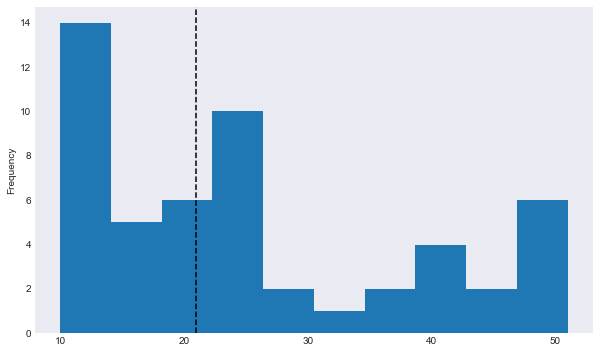

In [29]:
freq_limit = 21
top_half_columns_freq = top_half_columns.groupby(top_half_columns).count()
ax = top_half_columns_freq.sort_values().plot.hist()
ax.axvline(freq_limit, color='k', linestyle='dashed')

Filter the best columns

In [30]:
best_columns = top_half_columns_freq[top_half_columns_freq > freq_limit].index
len(best_columns), len(X_train.columns)

(29, 52)

Set the data for training

In [31]:
X_train = X_train[best_columns]
X_valid = X_valid[best_columns]
X_test = X_test[best_columns]

#### Save best features

In [32]:
# best_columns.to_series().to_csv(BEST_FEATURES_PATH)

## Training

### Random Forest Classifier

In [33]:
B = 1200

rf_model = RandomForestClassifier(
    n_estimators=B,
    criterion='entropy',
    max_depth=None,   # expand until all leaves are pure or contain < MIN_SAMPLES_SPLIT samples
    min_samples_split=100,
    min_samples_leaf=50,
    min_weight_fraction_leaf=0.0,
    max_features=None,   # number of features to consider when looking for the best split; None: max_features=n_features
    max_leaf_nodes=None,   # None: unlimited number of leaf nodes
    bootstrap=True,
    oob_score=True,   # estimate Out-of-Bag Cross Entropy
#     n_jobs=cpu_count() - 2,   # paralellize over all CPU cores but 2
    class_weight=None,    # our classes are skewed, but but too skewed
#     random_state=RANDOM_SEED,
    verbose=0,
    warm_start=False
)

rf_model.fit(X=pd.get_dummies(X_train), y=y_train.values.ravel())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=50, min_samples_split=100,
            min_weight_fraction_leaf=0.0, n_estimators=1200, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

### Gradient Boosting Classifier

In [34]:
B = 2400

boost_model = GradientBoostingClassifier(
    n_estimators=B,
    loss='deviance',   # a.k.a Cross Entropy in Classification
    learning_rate=.01,   # shrinkage parameter
    subsample=1.,
    min_samples_split=200,
    min_samples_leaf=100,
    min_weight_fraction_leaf=0.0,
    max_depth=10,   # maximum tree depth / number of levels of interaction
    init=None,
#     random_state=RANDOM_SEED,
    max_features=None,   # number of features to consider when looking for the best split; None: max_features=n_features
    verbose=0,
    max_leaf_nodes=None,   # None: unlimited number of leaf nodes
    warm_start=False
)

boost_model.fit(X=pd.get_dummies(X_train), y=y_train.values.ravel())

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=10,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=100, min_samples_split=200,
              min_weight_fraction_leaf=0.0, n_estimators=2400,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

### Metrics

In [35]:
low_prob = 1e-6
high_prob = 1 - low_prob
log_low_prob = np.log(low_prob)
log_high_prob = np.log(high_prob)
log_prob_thresholds = np.linspace(start=log_low_prob, stop=log_high_prob, num=100)
prob_thresholds = np.exp(log_prob_thresholds)

In [36]:
rf_pred_probs = rf_model.predict_proba(X=pd.get_dummies(X_valid))
rf_oos_performance = bin_classif_eval(
    rf_pred_probs[:, 1], 
    y_valid.values.ravel() == 'yes',
    pos_cat='yes',
    thresholds=prob_thresholds
)
print('Done!')

Done!


c:\users\yurih\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in long_scalars


In [37]:
boost_pred_probs = boost_model.predict_proba(X=pd.get_dummies(X_valid))
boost_oos_performance = bin_classif_eval(
    boost_pred_probs[:, 1], 
    y_valid.values.ravel() == 'yes', 
    pos_cat='yes', 
    thresholds=prob_thresholds
)
print('Done!')

Done!


c:\users\yurih\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in long_scalars


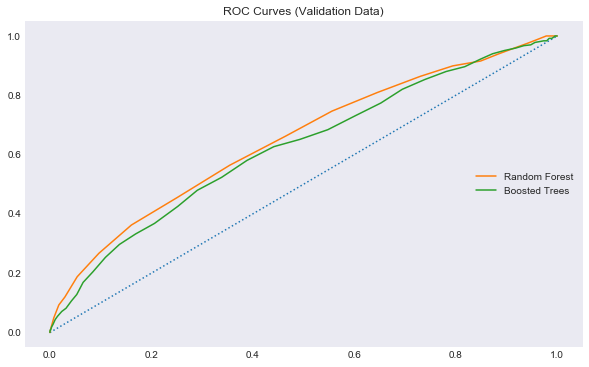

In [38]:
pyplot.plot(
    [0, 1], [0, 1],
    linestyle='dotted')
pyplot.plot(
    1 - rf_oos_performance.specificity,
    rf_oos_performance.recall,
    label='Random Forest')
pyplot.plot(
    1 - boost_oos_performance.specificity,
    boost_oos_performance.recall,
    label='Boosted Trees')
title('ROC Curves (Validation Data)')
legend(loc='right')
# savefig('./graphs/roc_curves_validation_data.png')

Select a arbitrary threshold to measure accuracy in the test data

In [45]:
recall_threshold = .25
idx = next(i for i in range(100) if rf_oos_performance.recall[i] <= recall_threshold) - 1
selected_prob_threshold = prob_thresholds[idx]
selected_prob_threshold

0.12328456933902097

In [46]:
rf_oos_performance.iloc[idx, :]

threshold      0.123285
accuracy       0.856800
recall         0.267030
specificity    0.903518
precision      0.179817
f1_score       0.214912
deviance       0.503049
Name: 84, dtype: float64

Test data metrics

In [47]:
rf_test_pred_probs = rf_model.predict_proba(X=pd.get_dummies(X_test))
rf_test_oos_performance = bin_classif_eval(
    rf_test_pred_probs[:, 1], 
    y_test.values.ravel() == 'yes',
    pos_cat='yes', 
    thresholds=selected_prob_threshold
)
rf_test_oos_performance

{'accuracy': 0.8580666666666666,
 'recall': 0.24330458465728552,
 'specificity': 0.9067885023563694,
 'precision': 0.17141029740965782,
 'f1_score': 0.20112570356472795,
 'deviance': 0.5049206927702956}

## AUC Pontuation

In [48]:
fpr, tpr, _ = metrics.roc_curve(y_test, rf_test_pred_probs[:, 1], pos_label='yes')
auc_pontuation = metrics.auc(fpr, tpr)
auc_pontuation

0.6481981150841166

## Save model

In [49]:
# pickle.dump(rf_model, open(MODEL_PATH, 'wb'))
# print('Model successfully saved!')

Model successfully saved!
